In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

# to play the audio files
from IPython.display import Audio
from sklearn.model_selection import train_test_split


from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from collections.abc import Iterable

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras import layers, callbacks

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

2025-04-29 22:43:34.033683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745966614.276752      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745966614.344566      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/musicgenreclassification/features_30_sec.csv')
if df['label'].dtype == 'object':
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])


df.drop(columns = ['filename'], inplace = True)

y = df['label']
X = df.drop(columns = ['label'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
best_params = {
    "subsample": 0.6,
    "reg_lambda": 1.5,
    "reg_alpha": 0.1,
    "n_estimators": 1000,
    "max_depth": 9,
    "learning_rate": 0.05,
    "gamma": 0,
    "colsample_bytree": 0.6
}

### Version 1

In [21]:
fractions = np.linspace(0.1, 1.0, 10)   # 10%,20%,…,100%
results = []

for f in fractions:
    n_samples = int(f * X_train_scaled.shape[0])
    rng = np.random.RandomState(42)
    idx = rng.choice(X_train_scaled.shape[0], n_samples, replace=False)
    
    X_sub = X_train_scaled[idx]
    y_sub = y_train.iloc[idx]
    
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        **best_params
    )
    model.fit(X_sub, y_sub)
    
    y_pred = model.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)
    f1m    = f1_score(y_test, y_pred, average='macro')
    
    results.append({
        'train_frac': f,
        'accuracy':   acc,
        'macro_f1':   f1m
    })


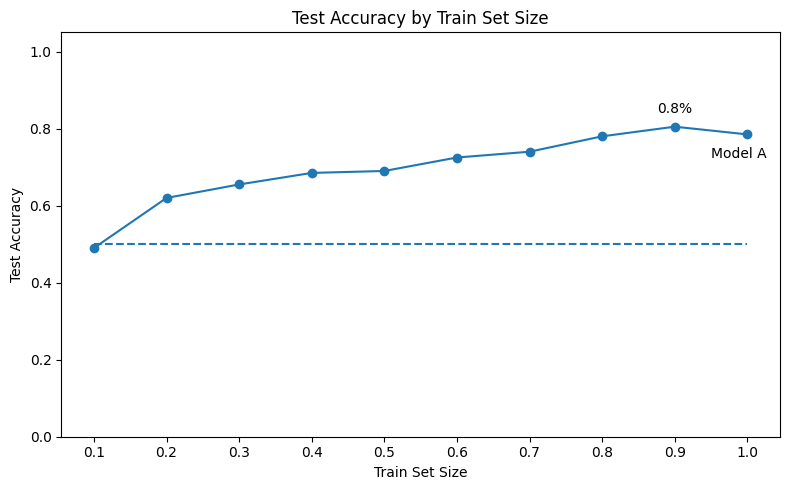

In [25]:
df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df['train_frac'], df['accuracy'], marker='o', label='Model A')
plt.hlines(0.5, df['train_frac'].min(), df['train_frac'].max(), linestyles='--', label='Baseline')

# Annotate the highest accuracy point
max_idx = df['accuracy'].idxmax()
x_max = df.loc[max_idx, 'train_frac']
y_max = df.loc[max_idx, 'accuracy']
plt.annotate(f"{y_max*100:.1f}%", (x_max, y_max),
             xytext=(0, 10), textcoords='offset points', ha='center')

# Label the curve at the end
plt.text(df['train_frac'].iat[-1] - 0.05, df['accuracy'].iat[-1] - 0.05,
         'Model A', va='center')

# Formatting
plt.xlabel('Train Set Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy by Train Set Size')
plt.xticks(df['train_frac'])
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig('Experiment4_part1.jpeg')
plt.show()

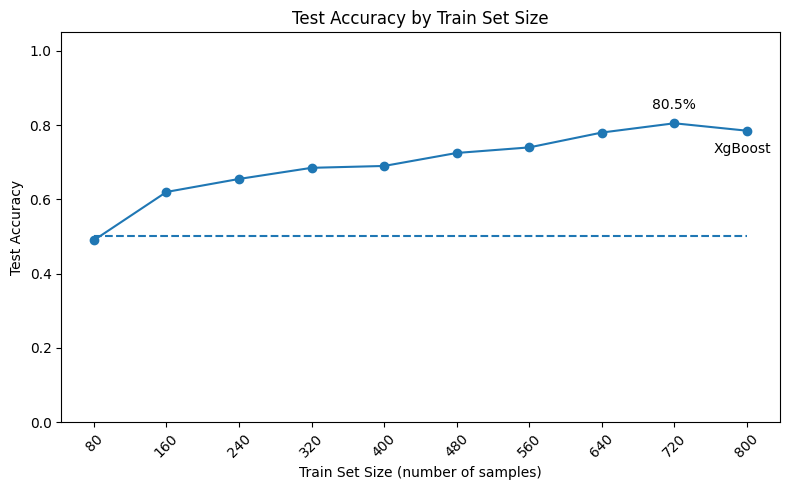

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# assuming you’ve already built `results` and your train split
n_train = X_train_scaled.shape[0]    # total number of training samples

df = pd.DataFrame(results)

# convert fraction → absolute sample count
df['train_size'] = (df['train_frac'] * n_train).astype(int)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df['train_size'], df['accuracy'], marker='o', label='Model A')
plt.hlines(0.5, df['train_size'].min(), df['train_size'].max(),
           linestyles='--', label='Baseline')

# Annotate the highest accuracy point
max_idx = df['accuracy'].idxmax()
x_max = df.loc[max_idx, 'train_size']
y_max = df.loc[max_idx, 'accuracy']
plt.annotate(f"{y_max*100:.1f}%", (x_max, y_max),
             xytext=(0, 10), textcoords='offset points', ha='center')

# Label the curve at the end
plt.text(df['train_size'].iat[-1] - int(n_train*0.047),
         df['accuracy'].iat[-1] - 0.05,
         'XgBoost', va='center')

# Formatting
plt.xlabel('Train Set Size (number of samples)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy by Train Set Size')
plt.xticks(df['train_size'], rotation=45)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig('Experiment4_part1.jpeg')
plt.show()

### Version 2

In [26]:
import tqdm

In [23]:
B = 100

accs, f1s = [], []
rng = np.random.RandomState(42)

for i in range(B):
    # sample with replacement from the train set
    idx = rng.choice(len(X_train_scaled), size=len(X_train_scaled), replace=True)
    X_boot = X_train_scaled[idx]
    y_boot = y_train.iloc[idx]
    
    # train & eval
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42,**best_params)
    model.fit(X_boot, y_boot)
    y_pred = model.predict(X_test_scaled)
    
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.733 ± 0.021
Macro F1:  0.739 ± 0.021


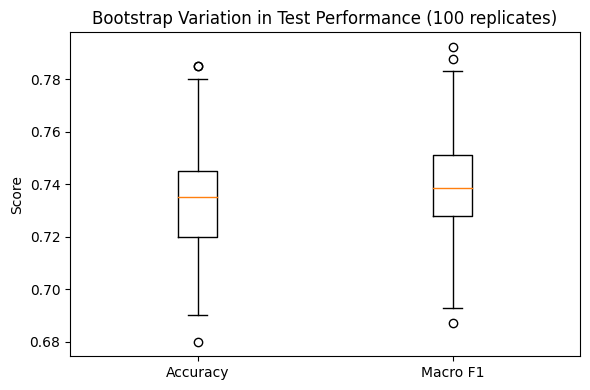

In [27]:
print(f"Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Macro F1:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

# boxplot of variation
plt.figure(figsize=(6,4))
plt.boxplot([accs, f1s], labels=['Accuracy','Macro F1'])
plt.title(f'Bootstrap Variation in Test Performance ({B} replicates)')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('BootstrapPerformance.jpeg')
plt.show()